In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
from gym import spaces
import random
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

class ClickPerceptionEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(ClickPerceptionEnv, self).__init__()
        self.target_angles = np.array([80, 90, 100])
        self.line_angles = np.array([88, 89, 90, 91, 92])
        self.observation_space = spaces.Box(low=0, high=180, shape=(2,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=180, shape=(1,), dtype=np.float32)  # 连续动作空间

    def reset(self):
        self.target_angle = np.random.choice(self.target_angles)
        self.line_angle = np.random.choice(self.line_angles)
        return np.array([self.target_angle, self.line_angle])

    def step(self, action_clicking_angle, action_line_pred):
        # 点击任务
        clicking_angle = action_clicking_angle
        clicking_reward = -abs(clicking_angle - self.target_angle)  # 越接近目标角度，奖励越高

        # 线段估计任务
        if self.line_angle > 90:
            direction = 1  # 右
        elif self.line_angle < 90:
            direction = 0  # 左
        else:
            direction = 0.5
        
        if action_line_pred[0][0] < action_line_pred[0][1]:
            pred_direction = 1
        elif action_line_pred[0][0] > action_line_pred[0][1]:
            pred_direction = 0
        else:
            pred_direction = 0.5

        if pred_direction == 0 and direction == 0:
            line_reward = 10
        elif pred_direction == 1 and direction == 1:
            line_reward = 10
        else:
            line_reward = 0

        reward = clicking_reward + line_reward
        done = True
        return np.array([self.target_angle, self.line_angle]), reward, done, {}

    def render(self, mode='human', close=False):
        pass

class ClickingModule(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, target_angle):
        output = self.network(target_angle)
        clicking_angle = output 
        return clicking_angle

class LineOrientationModule(nn.Module):
    def __init__(self, hidden_size=64, use_clicking=False):
        super().__init__()
        input_size = 1 if not use_clicking else 2
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)  
        )
        
    def forward(self, line_angle, clicking_angle=None):
        if clicking_angle is not None:
            x = torch.cat((line_angle, clicking_angle), dim=-1)
        else:
            x = line_angle
        return self.network(x)

class IndependentAgent(nn.Module):
    def __init__(self, hidden_size=64):
        super(IndependentAgent, self).__init__()
        self.clicking = ClickingModule(hidden_size)
        self.line_orientation = LineOrientationModule(hidden_size, use_clicking=False)

    def forward(self, state):
        target_angle = state[:, 0].unsqueeze(-1)
        line_angle = state[:, 1].unsqueeze(-1)
        clicking_angle = self.clicking(target_angle)
        line_pred = self.line_orientation(line_angle)
        return clicking_angle, line_pred

class CombinedAgent(nn.Module):
    def __init__(self, hidden_size=64):
        super(CombinedAgent, self).__init__()
        self.clicking = ClickingModule(hidden_size)
        self.line_orientation = LineOrientationModule(hidden_size, use_clicking=True)

    def forward(self, state):
        target_angle = state[:, 0].unsqueeze(-1)  
        line_angle = state[:, 1].unsqueeze(-1)    
        clicking_angle = self.clicking(target_angle)
        clicking_angle = clicking_angle.squeeze(-1)  

        if clicking_angle.dim() < line_angle.dim():
            clicking_angle = clicking_angle.unsqueeze(0)
        elif clicking_angle.dim() > line_angle.dim():
            line_angle = line_angle.unsqueeze(0)

        line_pred = self.line_orientation(line_angle, clicking_angle)
        return clicking_angle, line_pred

# 保存模型
def save_model(model, path):
    torch.save(model.state_dict(), path)

# 加载模型
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

def evaluate_model(model, env, n_trials=100):
    model.eval()
    results = {angle: {'clicking_angle': [], 'predictions': [], 'line_orientation_correct': 0} for angle in env.target_angles}
    total_predictions = {angle: {'left': 0, 'right': 0} for angle in env.target_angles}
    
    with torch.no_grad():
        for _ in range(n_trials):
            state = torch.tensor(env.reset(), dtype=torch.float32).unsqueeze(0)
            clicking_angle, line_pred = model(state)
            clicking_angle = clicking_angle.squeeze().item()
            _, reward, done, _ = env.step(clicking_angle, line_pred)
            target_angle = state[0, 0].item()
            
            results[target_angle]['clicking_angle'].append(clicking_angle)
            results[target_angle]['predictions'].append(line_pred[0, 1].item())
            
            # 检查line orientation预测是否正确
            if env.line_angle.item() > 90:
                if line_pred[0][0] > line_pred[0][1]:
                    results[target_angle]['line_orientation_correct'] += 0  # 假设大于90度为正向
                elif line_pred[0][0] < line_pred[0][1]:
                    results[target_angle]['line_orientation_correct'] += 1  # 假设大于90度为正向
            elif env.line_angle.item() < 90:
                if line_pred[0][0] > line_pred[0][1]:
                    results[target_angle]['line_orientation_correct'] += 1  # 假设大于90度为正向
                elif line_pred[0][0] < line_pred[0][1]:
                    results[target_angle]['line_orientation_correct'] += 0  # 假设大于90度为正向
            # elif env.line_angle.item() == 90:
            #     if line_pred[0][0] > line_pred[0][1]:
            #         total_predictions[target_angle]['left'] += 1
            #     else:
            #         total_predictions[target_angle]['right'] += 1

    # 计算line orientation的预测正确率
    for angle in env.target_angles:
        results[angle]['line_orientation_correct'] /= n_trials
        total_left_right = total_predictions[angle]['left'] + total_predictions[angle]['right']
        if total_left_right > 0:
            total_predictions[angle]['left'] /= total_left_right
            total_predictions[angle]['right'] /= total_left_right

    return results, total_predictions

def visualize_results(model1_results, model2_results):
    plt.figure(figsize=(10, 6))
    
    angles = sorted(model1_results.keys())

    data1 = [np.mean(model1_results[angle]['clicking_angle']) for angle in angles]
    data2 = [np.mean(model2_results[angle]['clicking_angle']) for angle in angles]
    
    x = np.arange(len(angles))
    print(data1)
    print(data2)
    width = 0.35
    
    plt.bar(x - width/2, data1, width, label='Model1')
    plt.bar(x + width/2, data2, width, label='Model2')
    plt.xlabel('Target Angle')
    plt.ylabel('Mean Clicking Angle (degrees)')
    plt.title('Mean Clicking Angle by Target Angle')
    plt.xticks(x, angles)
    plt.legend()
    plt.show()

# line orientation的正确率
def visualize_line_orientation(results):
    plt.figure(figsize=(10, 6))
    angles = sorted(results.keys())
    accuracies = [results[angle]['line_orientation_correct'] for angle in angles]
    print(accuracies)
    
    plt.bar(angles, accuracies, color='blue')
    plt.xlabel('Target Angle')
    plt.ylabel('Line Orientation Accuracy')
    plt.title('Line Orientation Prediction Accuracy by Target Angle')
    plt.savefig('./reinforcement_learning_line_orientation_acc.png')
    plt.show()

# prediction为90度时两个模型预测的向左或向右的比例
def visualize_clicking_proportions(total_predictions):
    plt.figure(figsize=(10, 6))
    angles = sorted(total_predictions.keys())
    left_proportions = [total_predictions[angle]['left'] if total_predictions[angle]['left'] + total_predictions[angle]['right'] > 0 else 0 for angle in angles]
    right_proportions = [total_predictions[angle]['right'] if total_predictions[angle]['left'] + total_predictions[angle]['right'] > 0 else 0 for angle in angles]
    
    plt.bar(angles, left_proportions, width=0.4, label='Left', color='red')
    plt.bar(angles, right_proportions, width=0.4, bottom=left_proportions, label='Right', color='green')
    plt.xlabel('Target Angle')
    plt.ylabel('Proportion')
    plt.title('Proportion of Left and Right Clicking when Line Prediction is 90 degrees')
    plt.legend()
    plt.savefig('./reinforcement_learning_clicking_proportions_model1.png')
    plt.show()


def train_agent(env, agent, n_episodes=1000):
    optimizer = optim.Adam(agent.parameters(), lr=0.001)
    clicking_losses = []
    line_losses = []
    
    for episode in range(n_episodes):
        state = torch.tensor(env.reset(), dtype=torch.float32).unsqueeze(0)
        done = False
        episode_clicking_loss = 0
        episode_line_loss = 0
        
        while not done:
            action_clicking_angle, line_pred = agent(state)
            action_clicking_angle = action_clicking_angle.squeeze().detach()
            next_state, reward, done, _ = env.step(action_clicking_angle.numpy(), line_pred.detach().numpy())
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(0)
            
            clicking_loss = -reward.mean()
            episode_clicking_loss += clicking_loss.item()
            
            line_loss = nn.CrossEntropyLoss()(line_pred, torch.tensor([1 if r.item() > 0 else 0 for r in reward]))
            episode_line_loss += line_loss.item()
            
            state = next_state
            
        clicking_losses.append(episode_clicking_loss / (episode + 1))
        line_losses.append(episode_line_loss / (episode + 1))
        
        optimizer.zero_grad()
        
        total_loss = torch.tensor(clicking_losses[-1] + line_losses[-1], requires_grad=True)
        total_loss.backward()
        optimizer.step()
    
    return clicking_losses, line_losses

def visualize_losses(clicking_losses, line_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(clicking_losses, label='Clicking Loss')
    plt.plot(line_losses, label='Line Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./reinforcement_learning_loss.png')
    plt.show()


Training Agent with Model1...
Training Agent with Model2...
[0.141, 0.126, 0.128]


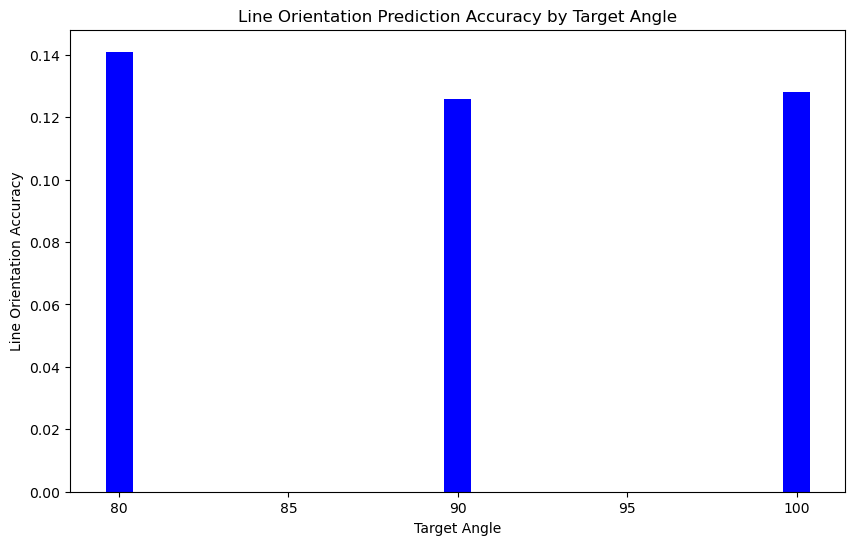

[0.145, 0.139, 0.133]


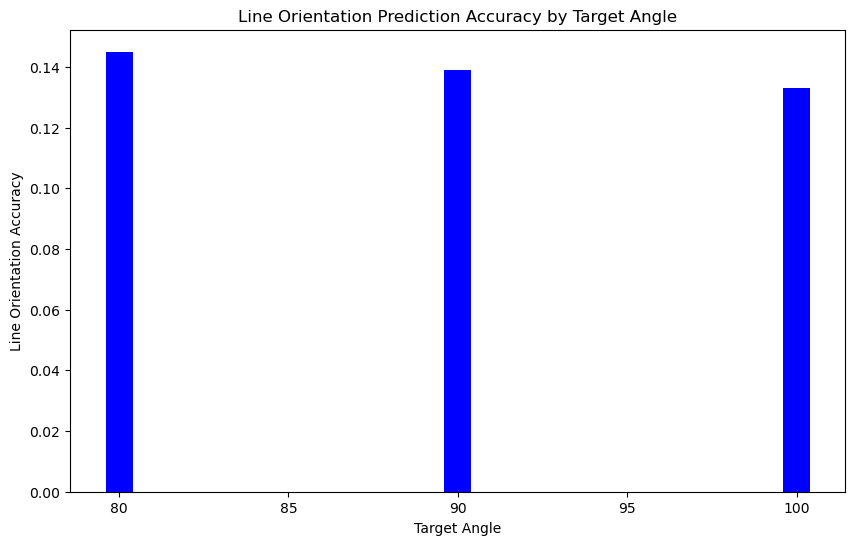

In [17]:
def main():
    env = ClickPerceptionEnv()
    agent_model1 = IndependentAgent()
    agent_model2 = CombinedAgent()
    
    print("Training Agent with Model1...")
    clicking_losses, line_losses = train_agent(env, agent_model1, n_episodes=100)
    # visualize_losses(clicking_losses, line_losses)
    import pandas as pd
    clicking_losses_df = pd.DataFrame(clicking_losses)
    line_losses_df = pd.DataFrame(line_losses)
    clicking_losses_df.to_csv('model1_clicking_losses.csv', index=False, header=False)
    line_losses_df.to_csv('model1_line_losses.csv', index=False, header=False)
    save_model(agent_model1, 'model1.pth')
    
    print("Training Agent with Model2...")
    clicking_losses, line_losses = train_agent(env, agent_model2, n_episodes=100)
    clicking_losses_df = pd.DataFrame(clicking_losses)
    line_losses_df = pd.DataFrame(line_losses)
    clicking_losses_df.to_csv('model2_clicking_losses.csv', index=False, header=False)
    line_losses_df.to_csv('model2_line_losses.csv', index=False, header=False)
    # visualize_losses(clicking_losses, line_losses)
    save_model(agent_model2, 'model2.pth')
    
    # agent_model1 = IndependentAgent()
    # agent_model2 = CombinedAgent()
    # load_model(agent_model1, 'model1.pth')
    # load_model(agent_model2, 'model2.pth')
    
    model1_results, model1_total_predictions = evaluate_model(agent_model1, env, n_trials=1000)
    model2_results, model2_total_predictions = evaluate_model(agent_model2, env, n_trials=1000)
    model1_results_df = pd.DataFrame(model1_results)
    model1_total_predictions_df = pd.DataFrame(model1_total_predictions)
    # model1_results_df.to_csv('model1_results.csv', index=True, header=True)
    # model1_total_predictions_df.to_csv('model1_total_predictions.csv', index=True, header=True)
    model2_results_df = pd.DataFrame(model2_results)
    model2_total_predictions_df = pd.DataFrame(model2_total_predictions)
    # model2_results_df.to_csv('model2_results.csv', index=True, header=True)
    # model2_total_predictions_df.to_csv('model2_total_predictions.csv', index=True, header=True)

    # visualize_results(model1_results, model2_results)
    visualize_line_orientation(model1_results)
    visualize_line_orientation(model2_results)
    # visualize_clicking_proportions(model1_total_predictions)
    # visualize_clicking_proportions(model2_total_predictions)

if __name__ == "__main__":
    main()